# Chainerのテスト
## 学習済みのモデルファイルを使って文字認識をやってみる
* chainerでつくられるモデルは、pickleパッケージを使ってダンプできる
* このダンプしてきたモデルを使って文字識別させる
 * 学習にはかなりの計算機コストがかかるが、学習済みモデルを使って判別させるだけなら、非力なマシンでも十分
 * スマホに搭載したりとかの応用も利く
* *注意* GPUで学習したモデルを非GPU環境でそのまま適用できないので注意
 * 今回の例では非GPU環境で学習させたのでそのあたり気にしないでOK

## 必要パッケージをインポート

In [7]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import six
import pickle

from sklearn.datasets import fetch_mldata
from chainer import computational_graph as c
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F

import data
import argparse

plt.style.use('ggplot')

## モデルファイルのロード

In [2]:
fid = open('test.model', 'rb')
model = pickle.load(fid)
fid.close()

## 文字画像データのロード
* MNISTの文字画像データをロードする
 * 既にDL済みならロードするだけ

In [4]:
print('load MNIST dataset')                                                # MNISTの手書き数字データ
mnist = data.load_mnist_data()
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255                                                          # 0-1に変換
mnist['target'] = mnist['target'].astype(np.int32)

# separate lavel and data
data_x = mnist['data']; data_y = mnist['target'];
N = len(data_x); print N

70000


## 文字認識の実態
* 訓練に使ったデータの中からランダムに100個サンプルしてきて、それを識別させる

In [5]:
def draw_digit3(data, n, ans, recog):
    size = 28
    plt.subplot(col, row, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)
    plt.title("ans=%d, recog=%d"%(ans,recog), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

<function matplotlib.pyplot.show>

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


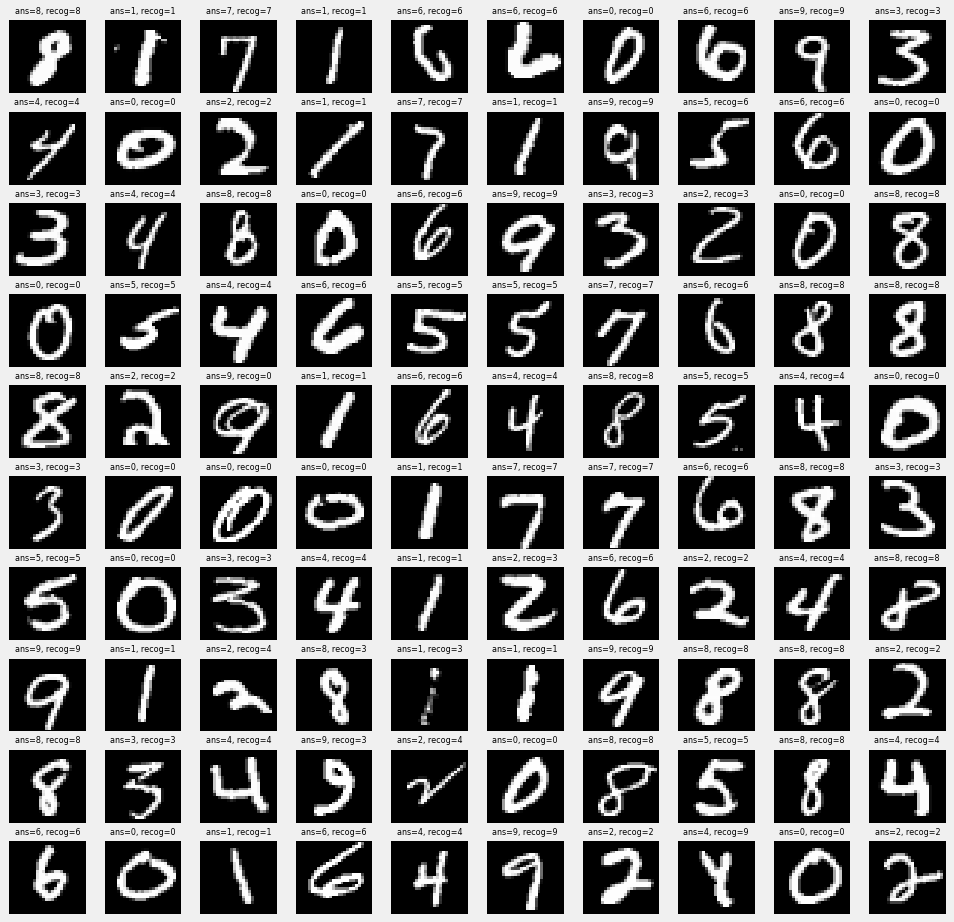

In [8]:
col = 10; row = 10;
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,15))
cnt = 0
for idx in np.random.permutation(N)[:(col*row)]:
    xxx = data_x[idx].astype(np.float32)
    h1 = F.dropout(F.relu(model.l1(Variable(xxx.reshape(1,784)))),  train=False)
    h2 = F.dropout(F.relu(model.l2(h1)), train=False)
    y  = model.l3(h2)
    cnt+=1
    draw_digit3(data_x[idx], cnt, data_y[idx], np.argmax(y.data))
plt.show